In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

## Pycaret

### Import

In [3]:
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Load file

In [4]:
train_df = pd.read_csv('./train.csv')
# 사용하지 않는 ID column 제거
train_df = train_df.drop('ID', axis=1)

train_x = train_df.drop('label', axis=1)
train_y = train_df['label']

### train, test data 분리

In [15]:
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=0, stratify=train_y)

### Setup

In [16]:
clf_setup = setup(session_id=0, data=x_train, target=y_train, fold_strategy='stratifiedkfold')

,Description,Value
0,Session id,0
1,Target,label
2,Target type,Binary
3,Original data shape,"(4900, 17)"
4,Transformed data shape,"(4900, 17)"
5,Transformed train set shape,"(3430, 17)"
6,Transformed test set shape,"(1470, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


### model 성능 비교

In [17]:
clf_models = compare_models(n_select=5, sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7245,0.8032,0.6413,0.6227,0.6310,0.4114,0.4123,0.3710
rf,Random Forest Classifier,0.7219,0.8068,0.6222,0.6225,0.6212,0.4017,0.4027,0.4290
gbc,Gradient Boosting Classifier,0.7204,0.8008,0.6397,0.6172,0.6265,0.4036,0.4052,0.3700
ada,Ada Boost Classifier,0.7157,0.7897,0.6262,0.6117,0.6178,0.3918,0.3928,0.3630
et,Extra Trees Classifier,0.7157,0.7984,0.5944,0.6195,0.6058,0.3839,0.3848,0.4140
xgboost,Extreme Gradient Boosting,0.7096,0.7867,0.6087,0.6049,0.6063,0.3764,0.3768,0.3750
qda,Quadratic Discriminant Analysis,0.7029,0.7790,0.7532,0.5794,0.6435,0.3984,0.4191,0.3640
lr,Logistic Regression,0.7026,0.7860,0.5405,0.6087,0.5714,0.3452,0.3474,0.3670
ridge,Ridge Classifier,0.7009,0.0000,0.5524,0.6030,0.5753,0.3454,0.3471,0.3830
lda,Linear Discriminant Analysis,0.6997,0.7880,0.5627,0.5985,0.5790,0.3462,0.3473,0.3780


### model tuning

In [18]:
tuned_models = [tune_model(clf_model, n_iter=100, optimize='Accuracy') for clf_model in clf_models]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7638,0.8166,0.6746,0.6800,0.6773,0.4911,0.4911
1,0.7055,0.7806,0.5476,0.6106,0.5774,0.3525,0.3537
2,0.7230,0.8042,0.5952,0.6303,0.6122,0.3971,0.3975
3,0.6851,0.7778,0.5317,0.5776,0.5537,0.3111,0.3118
4,0.7347,0.7801,0.6349,0.6400,0.6375,0.4283,0.4283
5,0.7434,0.8041,0.6429,0.6532,0.6480,0.4462,0.4462
6,0.7172,0.8001,0.6905,0.6000,0.6421,0.4102,0.4130
7,0.7697,0.8318,0.6984,0.6822,0.6902,0.5069,0.5070
8,0.7172,0.7678,0.6587,0.6058,0.6312,0.4025,0.4034


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7318,0.8143,0.6984,0.6197,0.6567,0.4379,0.4400
1,0.7464,0.8108,0.6667,0.6512,0.6588,0.4570,0.4571
2,0.7347,0.8140,0.6429,0.6378,0.6403,0.4302,0.4302
3,0.7230,0.7944,0.6587,0.6148,0.6360,0.4129,0.4136
4,0.7347,0.7995,0.6746,0.6296,0.6513,0.4376,0.4383
5,0.7114,0.7817,0.6032,0.6080,0.6056,0.3780,0.3780
6,0.6822,0.7733,0.6667,0.5563,0.6065,0.3436,0.3476
7,0.7493,0.8455,0.6349,0.6667,0.6504,0.4551,0.4555
8,0.7201,0.7772,0.6905,0.6042,0.6444,0.4154,0.4179


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7347,0.8141,0.6349,0.6400,0.6375,0.4283,0.4283
1,0.7318,0.8126,0.5952,0.6466,0.6198,0.4132,0.4140
2,0.7434,0.8139,0.5714,0.6792,0.6207,0.4290,0.4327
3,0.7289,0.7955,0.6270,0.6320,0.6295,0.4157,0.4157
4,0.7026,0.7892,0.6270,0.5896,0.6077,0.3686,0.3691
5,0.7347,0.7937,0.6032,0.6496,0.6255,0.4205,0.4212
6,0.6968,0.7818,0.6270,0.5809,0.6031,0.3583,0.3590
7,0.7289,0.8333,0.5714,0.6486,0.6076,0.4017,0.4036
8,0.7318,0.7837,0.6111,0.6417,0.6260,0.4171,0.4174


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7143,0.7863,0.6349,0.6061,0.6202,0.3914,0.3917
1,0.7085,0.8018,0.6190,0.6000,0.6094,0.3769,0.3770
2,0.7580,0.8151,0.6270,0.6870,0.6556,0.4697,0.4708
3,0.7143,0.8008,0.6349,0.6061,0.6202,0.3914,0.3917
4,0.7201,0.7820,0.6190,0.6190,0.6190,0.3978,0.3978
5,0.7055,0.7719,0.5873,0.6016,0.5944,0.3633,0.3634
6,0.6880,0.7781,0.6984,0.5605,0.6219,0.3618,0.3681
7,0.7668,0.8485,0.6349,0.7018,0.6667,0.4880,0.4894
8,0.7318,0.7910,0.6746,0.6250,0.6489,0.4324,0.4332


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7493,0.8089,0.7063,0.6449,0.6742,0.4711,0.4724
1,0.7172,0.8011,0.6587,0.6058,0.6312,0.4025,0.4034
2,0.7493,0.8204,0.6667,0.6562,0.6614,0.4624,0.4624
3,0.7201,0.7983,0.6429,0.6136,0.6279,0.4038,0.4041
4,0.7318,0.7939,0.6508,0.6308,0.6406,0.4268,0.4269
5,0.6822,0.7648,0.5556,0.5691,0.5622,0.3129,0.3129
6,0.6968,0.7667,0.6984,0.5714,0.6286,0.3767,0.3821
7,0.7668,0.8455,0.6429,0.6983,0.6694,0.4897,0.4907
8,0.7201,0.7904,0.6508,0.6119,0.6308,0.4058,0.4063


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [19]:
for i, clf_model in enumerate(tuned_models):
    save_model(clf_model, f'./model{i}')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


### blend model

In [21]:
blended_model = blend_models(estimator_list=tuned_models, optimize='Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7551,0.8231,0.6825,0.6615,0.6719,0.4766,0.4768
1,0.7230,0.8124,0.5873,0.6325,0.6091,0.3951,0.3957
2,0.7347,0.8217,0.6032,0.6496,0.6255,0.4205,0.4212
3,0.7143,0.7945,0.6190,0.6094,0.6142,0.3873,0.3874
4,0.7259,0.7960,0.6587,0.6194,0.6385,0.4181,0.4187
5,0.7230,0.7954,0.6270,0.6220,0.6245,0.4051,0.4051
6,0.7026,0.7908,0.6905,0.5800,0.6304,0.3848,0.3889
7,0.7580,0.8497,0.6508,0.6777,0.6640,0.4750,0.4753
8,0.7464,0.7883,0.6905,0.6444,0.6667,0.4624,0.4631


### final train

In [22]:
final_model = finalize_model(blended_model)

### final model 성능 체크

In [24]:
preds = predict_model(final_model, data=x_test)['prediction_label']
acc = accuracy_score(preds, y_test)
acc

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


0.7314285714285714

## features importance analysis

각 features의 importance를 측정하여 시각화하였다. 모델은 compare_model에서 Accuracy지표가 가장 좋은 lightgbm을 tuning하여 사용하였다.

In [28]:
#lgbm = create_model('lightgbm', fold=5)
lgbm = tuned_models[0]
lgbm.fit(x_train, y_train)
feature_importance = lgbm.feature_importances_
feature_importance

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 1800, number of negative: 3100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove th

array([162, 138,  74, 177, 204,  30, 236, 205, 342, 133, 234, 250, 273,
       280,   8, 294])

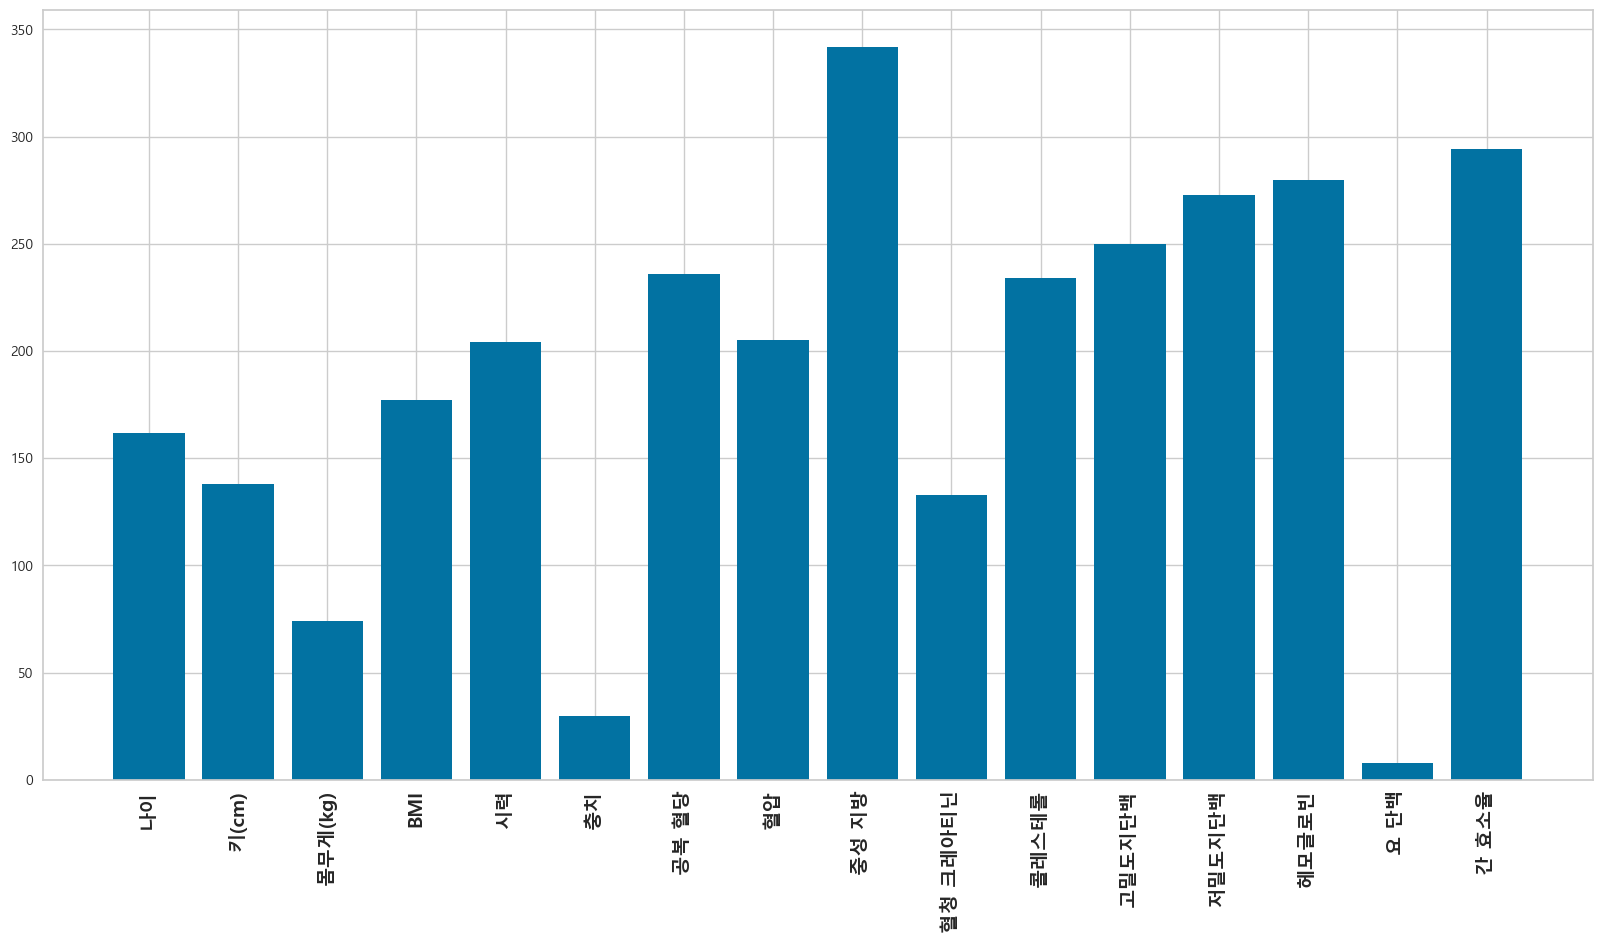

In [43]:
plt.figure(figsize=(20,10))
plt.bar(x_train.columns, feature_importance)
plt.xticks(fontsize=14, rotation=90, weight='bold')
plt.show()

요단백과 충치의 feature_importance가 매우 낮으므로 흡연여부 예측 모델에서 제외한다.

BMI는 키(cm)와 몸무게(kg)과 상관관계가 높고 BMI의 feature_importance가 가장 높으므로 키(cm)와 몸무게(kg)을 모델에서 제외한다.

저밀도지단백과 콜레스테롤 역시 상관관계가 높고 저밀도지단백의 feature_importance가 더 높으므로 콜레스테롤을 모델에서 제외한다.

In [5]:
new_train_x = train_x.drop(columns=['키(cm)', '몸무게(kg)', '충치', '콜레스테롤', '요 단백'])

새로운 columns로 학습과정을 다시 실행한다.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(new_train_x, train_y, test_size=0.3, random_state=0, stratify=train_y)

In [7]:
clf_setup = setup(session_id=0, data=x_train, target=y_train, fold_strategy='stratifiedkfold')

,Description,Value
0,Session id,0
1,Target,label
2,Target type,Binary
3,Original data shape,"(4900, 12)"
4,Transformed data shape,"(4900, 12)"
5,Transformed train set shape,"(3430, 12)"
6,Transformed test set shape,"(1470, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [11]:
clf_models = compare_models(n_select=5, sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7157,0.7876,0.6071,0.6183,0.6109,0.3874,0.3888,2.5330
rf,Random Forest Classifier,0.7137,0.7907,0.5857,0.6180,0.6002,0.3777,0.3790,2.5530
ada,Ada Boost Classifier,0.7134,0.7747,0.5929,0.6173,0.6034,0.3795,0.3808,2.4990
xgboost,Extreme Gradient Boosting,0.7114,0.7816,0.5944,0.6111,0.6014,0.3756,0.3766,3.0130
lightgbm,Light Gradient Boosting Machine,0.7087,0.7843,0.5968,0.6069,0.6008,0.3718,0.3726,2.8860
et,Extra Trees Classifier,0.7073,0.7892,0.5341,0.6197,0.5724,0.3520,0.3552,3.0530
qda,Quadratic Discriminant Analysis,0.6974,0.7651,0.5889,0.5900,0.5881,0.3493,0.3503,2.4520
lr,Logistic Regression,0.6910,0.7759,0.4952,0.5981,0.5405,0.3110,0.3150,2.9550
nb,Naive Bayes,0.6892,0.7575,0.6413,0.5697,0.6026,0.3492,0.3515,2.4850
ridge,Ridge Classifier,0.6889,0.0000,0.4825,0.5970,0.5323,0.3034,0.3082,2.4770


In [15]:
tuned_models = [tune_model(clf_model, n_iter=100, optimize='Accuracy') for clf_model in clf_models]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7114,0.7819,0.5952,0.6098,0.6024,0.3759,0.3760
1,0.7259,0.7934,0.5635,0.6455,0.6017,0.3943,0.3964
2,0.7405,0.8232,0.5476,0.6832,0.6079,0.4175,0.4232
3,0.6997,0.8044,0.5794,0.5935,0.5863,0.3507,0.3508
4,0.7318,0.7834,0.5952,0.6466,0.6198,0.4132,0.4140
5,0.7259,0.7845,0.5079,0.6667,0.5766,0.3794,0.3871
6,0.6939,0.7819,0.5952,0.5814,0.5882,0.3447,0.3447
7,0.7434,0.8356,0.5635,0.6827,0.6174,0.4271,0.4315
8,0.7230,0.7747,0.5952,0.6303,0.6122,0.3971,0.3975


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6997,0.7809,0.6429,0.5827,0.6113,0.3676,0.3688
1,0.6968,0.7778,0.6190,0.5821,0.6000,0.3562,0.3567
2,0.7493,0.8180,0.6587,0.6587,0.6587,0.4606,0.4606
3,0.7026,0.7945,0.6349,0.5882,0.6107,0.3707,0.3714
4,0.7434,0.7843,0.6587,0.6484,0.6535,0.4499,0.4499
5,0.7143,0.7845,0.5556,0.6250,0.5882,0.3706,0.3721
6,0.6939,0.7716,0.6508,0.5734,0.6097,0.3595,0.3615
7,0.7405,0.8289,0.6032,0.6609,0.6307,0.4313,0.4324
8,0.7143,0.7681,0.6349,0.6061,0.6202,0.3914,0.3917


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6910,0.7512,0.6190,0.5735,0.5954,0.3460,0.3467
1,0.7085,0.7783,0.5714,0.6102,0.5902,0.3643,0.3648
2,0.7464,0.8122,0.5635,0.6893,0.6201,0.4326,0.4375
3,0.7085,0.7858,0.6032,0.6032,0.6032,0.3728,0.3728
4,0.7172,0.7716,0.6032,0.6179,0.6104,0.3885,0.3886
5,0.7085,0.7695,0.5476,0.6161,0.5798,0.3578,0.3593
6,0.6997,0.7763,0.6270,0.5852,0.6054,0.3635,0.3640
7,0.7551,0.8263,0.5714,0.7059,0.6316,0.4512,0.4569
8,0.7318,0.7769,0.6190,0.6393,0.6290,0.4191,0.4192


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7259,0.7665,0.6587,0.6194,0.6385,0.4181,0.4187
1,0.6997,0.7727,0.5635,0.5966,0.5796,0.3463,0.3467
2,0.7143,0.7884,0.5476,0.6273,0.5847,0.3685,0.3705
3,0.6997,0.7596,0.5952,0.5906,0.5929,0.3550,0.3550
4,0.7172,0.7757,0.6349,0.6107,0.6226,0.3966,0.3968
5,0.7259,0.7805,0.5714,0.6429,0.6050,0.3963,0.3979
6,0.6764,0.7593,0.6111,0.5540,0.5811,0.3185,0.3195
7,0.7347,0.8092,0.6270,0.6423,0.6345,0.4263,0.4264
8,0.6939,0.7434,0.6508,0.5734,0.6097,0.3595,0.3615


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7318,0.7765,0.6825,0.6232,0.6515,0.4342,0.4354
1,0.6968,0.7685,0.5556,0.5932,0.5738,0.3389,0.3393
2,0.7376,0.7917,0.5873,0.6607,0.6218,0.4220,0.4237
3,0.7114,0.7821,0.5714,0.6154,0.5926,0.3696,0.3702
4,0.7172,0.7657,0.6429,0.6090,0.6255,0.3986,0.3990
5,0.7376,0.7879,0.5873,0.6607,0.6218,0.4220,0.4237
6,0.6997,0.7897,0.6429,0.5827,0.6113,0.3676,0.3688
7,0.7522,0.8122,0.6032,0.6847,0.6414,0.4532,0.4553
8,0.7201,0.7642,0.6270,0.6172,0.6220,0.3998,0.3999


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [10]:
blended_model = blend_models(estimator_list=tuned_models, optimize='Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7289,0.7849,0.6746,0.6204,0.6464,0.4272,0.4281
1,0.7085,0.7868,0.5635,0.6121,0.5868,0.3621,0.3629
2,0.7376,0.8096,0.5714,0.6667,0.6154,0.4181,0.4209
3,0.7201,0.7908,0.6190,0.6190,0.6190,0.3978,0.3978
4,0.7289,0.7810,0.6587,0.6241,0.6409,0.4234,0.4238
5,0.7289,0.7928,0.5635,0.6514,0.6043,0.3997,0.4021
6,0.6968,0.7817,0.6508,0.5775,0.6119,0.3646,0.3663
7,0.7493,0.8253,0.6270,0.6695,0.6475,0.4533,0.4539
8,0.7201,0.7668,0.6508,0.6119,0.6308,0.4058,0.4063


In [11]:
final_model = finalize_model(blended_model)

In [12]:
preds = predict_model(final_model, data=x_test)['prediction_label']
acc = accuracy_score(preds, y_test)
acc

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


0.719047619047619

### submission

train data 전체를 재학습하여 위의 모델로 test set을 예측해본다.

In [13]:
clf_setup = setup(session_id=0, data=new_train_x, target=train_y, fold_strategy='stratifiedkfold')
test_x = pd.read_csv('./test.csv')
test_x = test_x[new_train_x.columns]
final_model = finalize_model(blended_model)
preds = predict_model(final_model, data=test_x)['prediction_label']
submission = pd.read_csv('./sample_submission.csv')
submission['label'] = preds
submission.to_csv('./sub1.csv', index = False)

,Description,Value
0,Session id,0
1,Target,label
2,Target type,Binary
3,Original data shape,"(7000, 12)"
4,Transformed data shape,"(7000, 12)"
5,Transformed train set shape,"(4900, 12)"
6,Transformed test set shape,"(2100, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


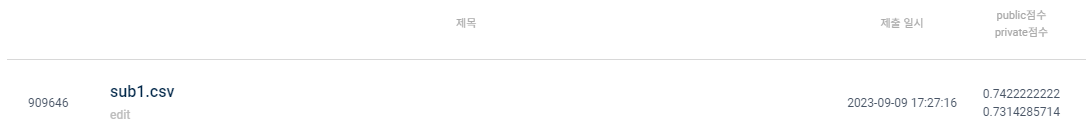

리더보드 결과 public 0.742, private 0.731의 Accuracy가 나왔다.

columns을 제외하지 않았던 이전의 모델로 리더보드 결과를 확인해보자.

In [9]:
tuned_models = []
for i in range(5):
    a = load_model(f'./model{i}')
    tuned_models.append(a)

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [14]:
clf_setup = setup(session_id=0, data=train_x, target=train_y, fold_strategy='stratifiedkfold')
test_x = pd.read_csv('./test.csv')
blended_model = blend_models(estimator_list=tuned_models, optimize='Accuracy')
final_model = finalize_model(blended_model)
preds = predict_model(final_model, data=test_x)['prediction_label']
submission = pd.read_csv('./sample_submission.csv')
submission['label'] = preds
submission.to_csv('./sub2.csv', index = False)


,Description,Value
0,Session id,0
1,Target,label
2,Target type,Binary
3,Original data shape,"(7000, 17)"
4,Transformed data shape,"(7000, 17)"
5,Transformed train set shape,"(4900, 17)"
6,Transformed test set shape,"(2100, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7592,0.8246,0.6944,0.6649,0.6793,0.4867,0.4870
1,0.6857,0.7796,0.6111,0.5670,0.5882,0.3347,0.3353
2,0.7020,0.7883,0.5722,0.5988,0.5852,0.3529,0.3532
3,0.7388,0.8098,0.6667,0.6383,0.6522,0.4432,0.4435
4,0.6939,0.7696,0.5889,0.5824,0.5856,0.3429,0.3429
5,0.7367,0.8278,0.6000,0.6545,0.6261,0.4235,0.4245
6,0.7469,0.8180,0.6556,0.6556,0.6556,0.4556,0.4556
7,0.7571,0.8423,0.6667,0.6704,0.6685,0.4769,0.4769
8,0.7020,0.7903,0.6222,0.5895,0.6054,0.3663,0.3667


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


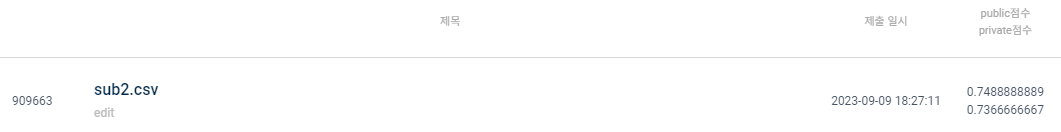

리더보드 결과 public 0.7489, private 0.7367의 Accuracy가 나왔다.
columns를 제외한 결과보다 이전의 model이 더 높은 Accuracy가 나왔다.

키(cm), 몸무게(kg), 콜레스테롤 columns를 제외한 것이 부정적인 영향을 끼친 것으로 보인다.

다시 충치와 요 단백만 제외한 모델로 예측해보자.

In [16]:
new_train_x_2 = train_x.drop(columns=['충치', '요 단백'])
x_train, x_test, y_train, y_test = train_test_split(new_train_x_2, train_y, test_size=0.3, random_state=0, stratify=train_y)
clf_setup = setup(session_id=0, data=x_train, target=y_train, fold_strategy='stratifiedkfold')
clf_model = compare_models(n_select=1, sort='Accuracy')
tuned_model = tune_model(clf_model, n_iter=100, optimize='Accuracy')
final_model = finalize_model(tuned_model)
preds = predict_model(final_model, data=x_test)['prediction_label']
acc = accuracy_score(preds, y_test)
acc

,Description,Value
0,Session id,0
1,Target,label
2,Target type,Binary
3,Original data shape,"(4900, 15)"
4,Transformed data shape,"(4900, 15)"
5,Transformed train set shape,"(3430, 15)"
6,Transformed test set shape,"(1470, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7227,0.7984,0.6492,0.6181,0.6320,0.4101,0.4115,5.2300
et,Extra Trees Classifier,0.7184,0.8016,0.6063,0.6205,0.6123,0.3915,0.3923,5.3940
xgboost,Extreme Gradient Boosting,0.7175,0.7887,0.6230,0.6159,0.6185,0.3944,0.3952,5.3140
lightgbm,Light Gradient Boosting Machine,0.7169,0.8002,0.6317,0.6121,0.6209,0.3953,0.3962,5.3170
rf,Random Forest Classifier,0.7160,0.8024,0.6183,0.6136,0.6151,0.3904,0.3910,5.3650
ada,Ada Boost Classifier,0.7157,0.7877,0.6198,0.6134,0.6154,0.3903,0.3912,5.2860
lda,Linear Discriminant Analysis,0.7052,0.7863,0.5659,0.6071,0.5842,0.3567,0.3584,5.3200
lr,Logistic Regression,0.7032,0.7849,0.5341,0.6104,0.5683,0.3441,0.3468,5.8510
ridge,Ridge Classifier,0.7032,0.0000,0.5516,0.6066,0.5762,0.3491,0.3511,5.4050
qda,Quadratic Discriminant Analysis,0.7032,0.7805,0.7460,0.5806,0.6396,0.3966,0.4172,5.3620


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7376,0.8105,0.6190,0.6500,0.6341,0.4298,0.4301
1,0.7289,0.8112,0.5794,0.6460,0.6109,0.4038,0.4052
2,0.7289,0.8262,0.5556,0.6542,0.6009,0.3976,0.4007
3,0.7085,0.7963,0.5873,0.6066,0.5968,0.3686,0.3687
4,0.7289,0.8014,0.5952,0.6410,0.6173,0.4078,0.4085
5,0.7114,0.7844,0.5635,0.6174,0.5892,0.3675,0.3684
6,0.6910,0.7684,0.6270,0.5725,0.5985,0.3481,0.3491
7,0.7580,0.8493,0.6032,0.6972,0.6468,0.4642,0.4671
8,0.7405,0.7871,0.6587,0.6434,0.6510,0.4445,0.4446


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


0.7223809523809523

submission

In [17]:
clf_setup = setup(session_id=0, data=new_train_x_2, target=train_y, fold_strategy='stratifiedkfold')
test_x = test_x[new_train_x_2.columns]
blended_model = blend_models(estimator_list=tuned_models, optimize='Accuracy')
final_model = finalize_model(tuned_model)
preds = predict_model(final_model, data=test_x)['prediction_label']
submission = pd.read_csv('./sample_submission.csv')
submission['label'] = preds
submission.to_csv('./sub3.csv', index = False)

,Description,Value
0,Session id,0
1,Target,label
2,Target type,Binary
3,Original data shape,"(7000, 15)"
4,Transformed data shape,"(7000, 15)"
5,Transformed train set shape,"(4900, 15)"
6,Transformed test set shape,"(2100, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7429,0.8222,0.6778,0.6421,0.6595,0.4531,0.4536
1,0.6939,0.7780,0.5944,0.5815,0.5879,0.3445,0.3445
2,0.7143,0.7915,0.6444,0.6042,0.6237,0.3938,0.3943
3,0.7327,0.8095,0.6556,0.6310,0.6431,0.4295,0.4297
4,0.6918,0.7757,0.6222,0.5744,0.5973,0.3484,0.3491
5,0.7490,0.8275,0.6056,0.6770,0.6393,0.4477,0.4494
6,0.7388,0.8173,0.6444,0.6444,0.6444,0.4380,0.4380
7,0.7694,0.8424,0.6722,0.6914,0.6817,0.5009,0.5011
8,0.7000,0.7931,0.6444,0.5829,0.6121,0.3685,0.3698


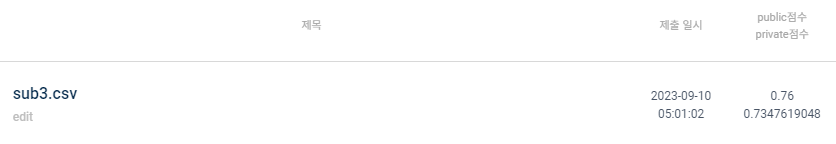

리더보드 Accuracy는 public에서는 개선이 있었지만 private에선 그러지 못하였다. 단순히 columns를 제외하는 것 만으로는 성능을 더욱 향상시키기 힘들어보인다.